# 심리검사 결과보고서에서 그래프 영역 탐지 모델

In [3]:
# cnn 학습을 위해 pdf 결과보고서를 이미지 형태로 변환이 필요함
# 허깅페이스에서 데이터 불러오기 (테스트)
from datasets import load_dataset

dataset = load_dataset("imdb")
print(dataset["train"][0])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [5]:
# 허깅페이스에서 결과보고서 pdf 데이터 불러오기
dataset = load_dataset("oddsends/KCMII_PDF")

## 표(table) 영역 탐지, 그래프(graph) 영역 탐지가 목적  
### PyMuPDF 패키지와 pdfplumber 패키지의 성능이 서로 다름  

PyMuPDF : 이미지 처리에 특화되어 있음  
pdfplumber : 표를 자동 인식해 데이터 처리가 좀 더 용이함  

PDF 파일 입력 후 파이프라인 기획이 안됨....


In [19]:
import pdfplumber

# 로컬 PDF 경로 지정
pdf_path = "kcmii2_001.pdf"  # 여기에 PDF 경로 입력

with pdfplumber.open(pdf_path) as pdf:
    page = pdf.pages[0]  # 첫 페이지

    # ① 텍스트 전체 추출
    print("전체 텍스트:\n", page.extract_text())

    # ② 단어별 박스 정보 추출 (표 후보 탐색용)
    words = page.extract_words(extra_attrs=["x0", "x1", "top", "bottom"])
    print("\n단어별 좌표:")
    for word in words:
        print(f"{word['text']:<20} (x0={word['x0']:.1f}, y0={word['top']:.1f}, x1={word['x1']:.1f}, y1={word['bottom']:.1f})")

    # ③ 표 추출 시도
    table = page.extract_table()
    print("\n표 추출 결과:")
    if table:
        for row in table:
            print(row)
    else:
        print("표를 감지하지 못했습니다.")


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


전체 텍스트:
 강서현
해석동영상을 확인하려면
스마트폰으로 스캔하세요.
전체 50개 중 50개 전체 50개 중 0개 전체 50개 중 0개
명문고등학교 1 학년 01 반 01번 강서현 여 2025년 03월 17일 G6f12c60ed8294a579f7f 없음
★ ★ ★ ★ ★
42 58 53 53 56 64 64 97 81 58 44 47 39 42 39 36 36 39 44 75 83 75 64 61 67 44 58 39 44 42 33 36 25 31 44 33 44 47 39 36 50 44 61 53 25 25 33 28 33 31
심리학, 상담심리학, 심리치료학, 미술심리상담학, 아
사회 심리
동상담심리학, 사회심리학
활동선호도
유아교육학, 보육학, 아동보육학, 영유아보육학, 아동 직업선호도
교육 유아교육
미술보육학, 아동학 전공교과선호도
사회복지학, 청소년학, 보건복지학, 가족학, 노인복지
사회 사회복지 학, 청소년복지학, 아동복지학, 여성복지학, 상담복지
학, 사회복지재활학, 사회복지경영학
심리 유아교육 사회복지 초등교육 교육
교육 초등교육 초등교육학
100 92 75 75 75
교육학, 교육공학, 평생교육학, 교육심리학, 교육과학,
교육 교육 100 83 92 75 67
국제평생교육학, 상담심리교육학, 청소년상담학
92 75 75 75 83

단어별 좌표:
명                    (x0=46.8, y0=162.4, x1=56.8, y1=172.4)
문                    (x0=56.2, y0=162.4, x1=66.2, y1=172.4)
고                    (x0=65.6, y0=162.4, x1=75.6, y1=172.4)
등                    (x0=75.0, y0=162.4, x1=85.0, y1=172.4)
학                    (x0=84.4, y0=162.4, x1=94.4, y1=172.4)
교                    (x0=93.8, y0=162

In [23]:
# pdfplumber 표 형태 인식 능력이 좋지 않음
# 텍스트는 잘 뽑아주지만, 표 형태 인식이 좋다고 가지고 왔는데 pymupdf 패키지보다 좋은게 없음
# pymupdf 텍스트 한번 추출해보고 하나만 쓸지 검토

import fitz  # PyMuPDF

doc = fitz.open(pdf_path)  # PDF 파일 경로
page = doc.load_page(0)        # 첫 페이지

text = page.get_text()         # 기본 텍스트 추출
print("줄 단위 텍스트:\n", text)

print("=============================================================")

blocks = page.get_text("blocks")  # (x0, y0, x1, y1, "text", block_no, block_type)
print("\n블록 단위 텍스트 및 위치:")

for b in blocks:
    print(f"Text: {b[4]}")
    print(f"Box: ({b[0]:.1f}, {b[1]:.1f}, {b[2]:.1f}, {b[3]:.1f})\n")

print("=============================================================")

words = page.get_text("words")  # (x0, y0, x1, y1, "word")
print("\n단어 단위 추출:")

for w in words:
    print(f"Word: {w[4]} | Box: ({w[0]:.1f}, {w[1]:.1f}, {w[2]:.1f}, {w[3]:.1f})")

줄 단위 텍스트:
 명문고등학교
1 학년 01 반 01번
강서현
여
2025년 03월 17일
G6f12c60ed8294a579f7f
사회
심리
심리학, 상담심리학, 심리치료학, 미술심리상담학, 아
동상담심리학, 사회심리학
교육
유아교육
유아교육학, 보육학, 아동보육학, 영유아보육학, 아동
미술보육학, 아동학
사회
사회복지
사회복지학, 청소년학, 보건복지학, 가족학, 노인복지
학, 청소년복지학, 아동복지학, 여성복지학, 상담복지
학, 사회복지재활학, 사회복지경영학
교육
초등교육
초등교육학
교육
교육
교육학, 교육공학, 평생교육학, 교육심리학, 교육과학, 
국제평생교육학, 상담심리교육학, 청소년상담학
전체 50개 중 50개
전체 50개 중 0개
전체 50개 중 0개
없음
★
★
★
★
★
42
58
53
53
56
64
64
97
81
58
44
47
39
42
39
36
36
39
44
75
83
75
64
61
67
44
58
39
44
42
33
36
25
31
44
33
44
47
39
36
50
44
61
53
25
25
33
28
33
31
심리
유아교육
사회복지
초등교육
교육
100
92
75
75
75
100
83
92
75
67
92
75
75
75
83
활동선호도
직업선호도
전공교과선호도
해석동영상을 확인하려면
 스마트폰으로 스캔하세요.
강서현


블록 단위 텍스트 및 위치:
Text: 명문고등학교
1 학년 01 반 01번
강서현
여
2025년 03월 17일
G6f12c60ed8294a579f7f

Box: (46.8, 162.4, 678.3, 172.4)

Text: 사회
심리
심리학, 상담심리학, 심리치료학, 미술심리상담학, 아
동상담심리학, 사회심리학

Box: (146.2, 604.4, 500.0, 625.4)

Text: 교육
유아교육
유아교육학, 보육학, 아동보육학, 영유아보육학, 아동
미술보육학, 아동학

Box: (146.2, 642.9, 500.0, 663.9)

Text: 사회
사회복지

Box: (146.2, 687.5, 26

### 두 패키지 텍스트 추출 자체는 비슷한 성능을 보임
### 그렇기 때문에 pymupdf 패키지로 개발하는 것으로 결정
### cnn으로 표 좌표와 그래프 좌표 인식하는걸로 개발
### 우선 kcmii에서 그래프와 표 좌표만 가지고 와서 학습

In [16]:
# pdf 좌표계에 대해서 알아야 이미지로 렌더링할 때 좌표가 어떻게 변화하는지 파악이 가능함.
# pdf는 내부적으로 모든 좌표를 포인트(pt) 단위로 관리
# 1pt = 1/72 inch (좌표 원점은 일반적으로 좌측 하단)
# 이미지 픽셀 수 = pdf pt 수 x (dpi / 72)
# dpi=72로 렌더링하면 pdf pt 1 = 이미지 px 1
# dpi=300이면 pdf pt 1 = 이미지 px 300/72

# pdf 파일 위에서 좌표 시각화
import fitz

pdf_path = "kcmii2_001.pdf"


# PDF 열기
doc = fitz.open(pdf_path)
page = doc.load_page(0)

# PDF 좌표계 상의 박스
pdf_bbox = fitz.Rect(100, 200, 300, 250)

# 빨간 사각형 주석 추가 (line width=1)
shape = page.new_shape()
shape.draw_rect(pdf_bbox)
shape.finish(color=(1, 0, 0), width=1)
shape.commit()

# 결과 저장 (PDF 상에서 사각형 시각화됨)
doc.save("highlighted_sample.pdf")

In [4]:
# 이미지 렌더링 후 좌표 시각화
from PIL import Image, ImageDraw

doc = fitz.open(pdf_path)
page = doc.load_page(0)
pdf_bbox = [100, 200, 300, 250]

dpi = 300
scale = dpi / 72
pix = page.get_pixmap(dpi=dpi) # dpi 크기만큼 pdf을 이미지로 변환
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples) # ?

# pdf 좌표 → 이미지 픽셀 좌표로 변환
image_bbox = [coord * scale for coord in pdf_bbox]
x0, y0, x1, y1 = image_bbox

# 이미지 위에 박스 시각화
draw = ImageDraw.Draw(img)
draw.rectangle([x0, y0, x1, y1], outline="red", width=3)

# 결과 이미지 보여주기
img.show()

### pdf 좌표값 입력시 이미지로 변환해서 확인할 수 있는 def  
* 예측 결과 및 학습 라벨링 디버깅 목적

In [11]:
def bbox_visualization(pdf_path, page_no, dpi, pdf_x0, pdf_y0, pdf_x1, pdf_y1) :
    from PIL import Image, ImageDraw # 필요한 패키지
    doc = fitz.open(pdf_path) # 객체 생성
    page = doc.load_page(page_no-1) # 객체의 불러올 페이지
    pdf_bbox = [pdf_x0, pdf_y0, pdf_x1, pdf_y1] # 객체에서의 좌표값
    scale = dpi / 72 # 이미지 변환할 때 좌표 스케일 보정
    pix = page.get_pixmap(dpi=dpi) # pdf 객체를 픽셀값으로 전환
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples) # 픽셀값을 받아서 실제 이미지 객체로 변환
    image_bbox = [coord * scale for coord in pdf_bbox] # pdf의 좌표값을 하나씩 coord에 담아서 이미지 좌표 스케일로 보정
    img_x0, img_y0, img_x1, img_y1 = image_bbox # 
    draw = ImageDraw.Draw(img)
    draw.rectangle([img_x0, img_y0, img_x1, img_y1], outline = "red", width=3)
    img.show()

In [13]:
bbox_visualization(pdf_path, 1, 300, 100, 200, 300, 500)

pdf를 이미지로 전환해서 정확한 좌표값을 어떻게 산출할지에 대해서 해결이 필요함  
* pdf를 이미지로 변환하고
* 마우스로 직접 좌표를 클릭해 지정할 수 있도록

In [16]:
!pip install Pillow

In [18]:
import fitz
from PIL import Image

def pdf_to_images(pdf_path, dpi=300):
    doc = fitz.open(pdf_path)
    for i, page in enumerate(doc):
        pix = page.get_pixmap(dpi=dpi)
        output_path = f"page_{i+1}.jpg"
        pix.save(output_path)
        print(f"Saved {output_path}")

Saved page_1.jpg
Axes(0.125,0.11;0.775x0.77)
[]


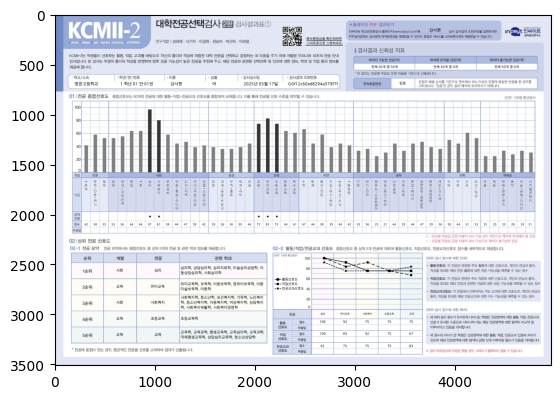

In [20]:
pdf_to_images(pdf_path, dpi=300)

import matplotlib.pyplot as plt
img = Image.open('page_1.jpg') # 해당 경로 이미지 열기
fig, ax = plt.subplots() # fig는 시각화하는 영역, ax는 좌표값 객체를 의미 / 인자가 없으면 1,1 기본값이 들어감
                            # 허공에 서브플롯 1,1 위치를 만들어 비어있는 fig안에 좌표 ax 만든것임
ax.imshow(img) # 이때 비어있는 fig안의 ax위치에 해당 이미지를 넣어서 보여줌
print(ax)
coords = [] # ? 뭔 용도인지 모르겠지만 비어있는 리스트 만들어놓음
print(coords)

In [ ]:
## 이미지(dpi=300)에서의 좌표
# 메인 막대그래프 좌표
'''
클릭된 좌표: (267.59, 882.23)
클릭된 좌표: (4796.34, 1591.87)
'''
# 메인 표
'''
클릭된 좌표: (272.75, 1991.84)
클릭된 좌표: (4793.76, 2195.70)
'''
# 꺽은선 막대그래프 좌표
'''
클릭된 좌표: (2569.38, 2407.30)
클릭된 좌표: (3678.99, 2949.20)
'''
# 꺽은선 표
'''
클릭된 좌표: (2566.80, 3052.42)
클릭된 좌표: (3668.67, 3405.95)
'''
# 상위 전공 표
'''
클릭된 좌표: (166.95, 2500.20)
클릭된 좌표: (2112.64, 3297.57)
'''

In [7]:
# 허깅페이스에 업로드되어 있는 pdf 파일 가지고와서 이미지로 변환
from datasets import load_dataset

dataset = load_dataset("oddsends/KCMII_PDF")

In [ ]:
import pdfpl

pdf_path = dataset[0]["file"]
with pdf

In [5]:
import os
print(os.getcwd())

c:\Users\qndba\report_error_detector\model_sketch


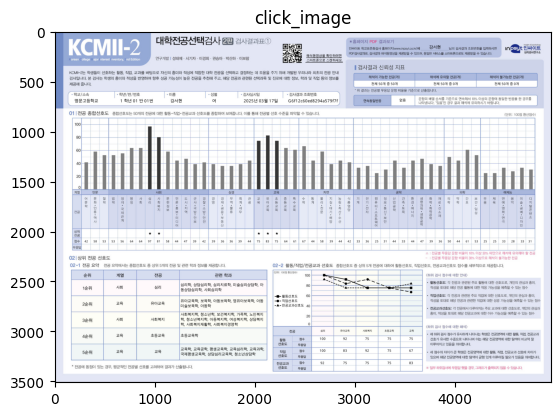

총 0개의 좌표가 저장되었습니다 -> coords.json


In [ ]:
# 디버깅용
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

def click_coords(image_path, save_path="coords.json"):
    coords = []  # 클릭된 좌표를 저장할 리스트

    # 클릭 이벤트에 반응하는 인터렉션을 정의하는 함수
    def onclick(event):
        if event.xdata is not None and event.ydata is not None: # event는 matplotlib의 이벤트 객체, xdata와 ydata는 moustevent의 인스턴트 객체
            x, y = event.xdata, event.ydata
            coords.append(x, y) # xdata, ydata 데이터를 coords 리스트에 저장 (튜플 형태로)
            print(f"클릭된 좌표: ({event.xdata:.2f}, {event.ydata:.2f})") # # xdata, ydata 프린팅
            ax.plot(event.xdata, event.ydata, 'ro')  # 해당 좌표 빨간 점 찍기
            fig.canvas.draw() # 빨간 점을 시각화 업데이트 해주기
    img = mpimg.imread(image_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title("click_image")
    fig.canvas.mpl_connect('button_press_event', onclick)
    # fig 데이터 구성 정보만 가지고 있는 층
    # canvas 실제로 그려주는 역할 
    # mpl_connect() 인자로 액션과 그 액션에서 발생하는 함수
    plt.show()
    # 마지막에 왜 보여주는거임?
    # re : 이벤트 리스터를 명시해주고 plt.show() 실행하는 순간 이벤트 리스터는 동작하게 되어 있음.
    # re : 즉 이벤트 리스터를 동작시켜라 라는 의미의 신호 같은 역할 + 시각화 플롯을 열어주는 역할
    with open(save_path, "w") as f :
        json.dump(coords, f)
    print(f"총 {len(coords)}개의 좌표가 저장되었습니다 -> {save_path}")

    return coords

if __name__ == "__main__" :
    click_coords("model_sketch/page_1.jpg")

In [9]:
coords = []  # 클릭된 좌표를 저장할 리스트
x, y = 1513.513, 813.12
coords.append([x, y]) # xdata, ydata 데이터를 coords 리스트에 저장 (튜플 형태로)
print(coords)

[[1513.513, 813.12]]
